## Accelerated binomial tree pricing

The general binomial model is $$S_n=S_i u^{Y_n}d^{n-Y_n}$$
where $Y_n=\sum_{i=1}^nZ_i$ for iid Bernoulli variables $Z_i$ with $P(Z_i=1)=p$. The model is specified by parameters $u,d,p$ which must be selected to give convergence to the geometric Brownian Motion (GBM) of the Black Scholes model, whose terminal value is
$$S_T=S_0e^{\sigma W_T-\frac12\sigma^2T}$$
Since the lognormal distribution of the GBM is characterised by its first two moments, there is an extra degree of freedom in specifying the tree. Moreover there is a degree of flexibility in how we converge to the first two moments, whether for example they are considered in spot ($S$) or log ($\ln S$) space. In this note we investigate the performance of three different configurations of tree:

 - **CRR**: The standard Cox-Ross-Rubenstein tree
 - **MM**: A strike-centred tree in which the first two moments of $S_t$ are matched exactly
 - **LogMM**: A strike-centred tree in which the first two moments of $\log S_t$ are matched exactly
 
Additionally we apply Richardson extrapolation (differencing of tree calculations with different number of steps to achieve a higher order of convergence rate) to the LogMM tree, in which case we find that its convergence rate for pricing European options far outperforms the CRR tree.

# Definition of tree specifications

### CRR tree

In the widely used Cox-Ross-Rubenstein tree used in our current pricing setup, the probability $p$ is determined by matching the first moment,

$$E[S_1]=pS_0u+(1-p)S_0d=S_0\qquad\Rightarrow\qquad p=\frac{1-d}{u-d}$$

Then the return multipliers are chosen as $u=1/d=e^{\sigma\sqrt{\Delta t}}$, and we have $var(\ln S_1)=(\ln\frac{u}{d})^2var(Z)=4\sigma^2\Delta tp(1-p)$, which converges in the limit to $\sigma^2\Delta t$, as $p\rightarrow \frac12$

### MM tree

The second moment in the CRR tree converges in the limit: we can instead specify the multipliers $u,d$ such that the second moment is matched for any $\Delta t$. The remaining degree of freedom may also be used to choose the positioning of the tree. Note that the central node of the final tree layer (if $n$ is even) $n\sqrt{ud}$. The CRR tree chooses the geometric average $\sqrt{ud}=1$ for a symmetric tree, but any value of $\sqrt{ud}=g$ could be chosen. For example the final layer of a tree with $g=\ln\frac{K}{S}$ will be centred on the option strike.

Applying the MGF of the binomial and Gaussian distributions to the discrete and continuous versions of $S_T$ allows us to equate the second moment,
$$var(S_T)=S_0^2\Big((1-p)d^2+pu^2)^n-1\Big)=S_0^2(e^{\sigma^2 T}-1)$$
Plugging in the same $p$ as in the CRR tree (which ensures $E[S]$ is correct) and rearranging gives an expression for the arithmetic average in terms of the geometric, $a:=(u+d)/2=\frac{1}{2}(e^{\sigma^2\Delta T}+g^2)$. Substituting back into this $g=\sqrt{d(2a-d)}=\sqrt{u(2a-u)}$ and solving gives the tree multipliers

$$u,d=a\pm\sqrt{a^2-g^2}$$

### LogMM tree

Instead of matching moments of $S$, we can choose to match moment of $\ln S$. Noting that choice of tree structure via $u,d$ is equivalent to choosing the positiona and spacing of the final tree layer via its minimal value $x_0=\ln(S_0d^n)$ and spacing $\Delta x=\ln(u/d)$, the moment matching criteria are
$$E[\ln S_T]=lnS_0-\frac12\sigma^2n\Delta t=x_0+np\Delta x$$
$$var[\ln S_T]=\sigma^2n\Delta T=np(1-p)\Delta x^2$$

A strike-centred tree gives $x_0+n/2=\ln K$ (in general we may substitute any value for $K$ to specify the centre of the tree), which can be substituted in to the conditions, and after some rearrangement we find
$$\Delta x=2\sigma\sqrt{\Delta t}\sqrt{1+\frac{d_2^2}{n}}$$
$$p=\frac{1}{2}\left(1+\frac{d2}{\sqrt{n+d_2^2}}\right)$$
where $d_2=-\frac{\ln K/F}{\sigma\sqrt T}-\frac{\sigma\sqrt{T}}{2}$ as in the Black-Scholes option pricing formula

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

In [40]:
def linspace(from_, to_, n):
    ''' Given two d-dimensional arrays (or things convertible to arrays) of the same shape,
        compute an (d+1)-dim array x of evenly spaced points between them, i.e. with
        x[i] = t*lo + (1-t)*i for "num_pts" evenly spaced values of t between 0 and 1.
        This is a generalisation of np.linspace
        evenly spaced'''
    from_ = np.asarray(from_)
    to_ = np.asarray(to_)
    from_ = from_.reshape([1]+list(from_.shape))
    to_ = to_.reshape([1]+list(to_.shape))
    theta = np.linspace(0,1,n).reshape([-1]+[1]*(len(from_.shape)-1))
    return from_ + theta * (to_-from_)

In [41]:
def bscall(F,K,v,T):
    x= np.log(K/F)
    y = v*np.sqrt(T)
    return F*norm.cdf(-x/y+y/2.)-K*norm.cdf(-x/y-y/2.)

def run_tree(x, p, payoff, pad=0):
    # pad :  the number of points either side of the first layer of the tree
    # e.g. if pad=1, x[0:3] are the values for x-dx, x and x+dx resp, used for delta ad gamma
    # compute the option value given the final tree layer x and the up-probability p
    # for the specified European-style payoff
    q=1.-p
    x = payoff(np.exp(x))
    for i in range(len(x)-1-2*pad):
        x[:-i-1]=q*x[:len(x)-i-1]+p*x[1:len(x)-i]
    return x[pad]

def run_tree_2(u,d,p,n,payoff):
    # compute the option value given the up/down return multipliers and the up-probability p
    # for the specified European-style payoff, using n steps
    x0 = np.log(F)+n * np.log(d)
    xn = np.log(F)+n * np.log(u)
    x = linspace(x0,xn,n)
    return run_tree(x,p,payoff)

In [42]:
def run_crr_tree(F,T,v,n,payoff):
    # crr tree
    # choose u=1/d
    # get u from matching var(lnS)=v**2*dt
    # get p from E[S]=S0
    dt = T/n
    u = np.exp(v*np.sqrt(dt))
    d = 1./u
    p = (1-d)/(u-d)
    return run_tree_2(u,d,p,n,payoff)

def run_mm_tree(F,T,v,n,payoff):
    # matching the 1st and 2nd moments in S space
    dt = T/n
    g=1 # geometric average, corresponds to np.sqrt(u*d), free choice to centre the tree as required
    a=0.5*(np.exp(v**2*dt)+g**2) # arithmetic average (u+d)/2, determined by matching 2nd moment var(ST)
    u = a+np.sqrt(a**2-g**2)
    d = a-np.sqrt(a**2-g**2)
    p = (1-d)/(u-d) # matching the 1st moment E[ST]
    return run_tree_2(u,d,p,n,payoff)

def run_logmm_tree(F,T,C,v,n,payoff, pad=1):    
    # matching the 1st and 2nd moments in logS space
    x = np.log(C/F) # C could be the strike value, or any point at which we want to centre the tree
    y = v*np.sqrt(T)
    d2=-x/y-y/2
    dx = 2*v*np.sqrt((T/n)*(1+(d2**2/n)))
    x0 = np.log(C)-n*dx/2.0-pad*dx # minimum value of x in the final layer of the tree
    x = linspace(x0,x0+(n+(2*pad))*dx,n+2*pad+1) # final tree layer
    p=0.5*(1+d2 /np.sqrt((n+(d2**2))))
    return run_tree(x,p,payoff, pad)

def run_logmm_rich_tree(F,T,C,v,n,payoff):
    # Richardson extrapolation for the logmm tree
    a = run_logmm_tree(F,T,C,v,n,payoff, pad=0)
    b = run_logmm_tree(F,T,C,v,int(n)/2,payoff, pad=0)
    return 2*a-b

/home/sejones/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


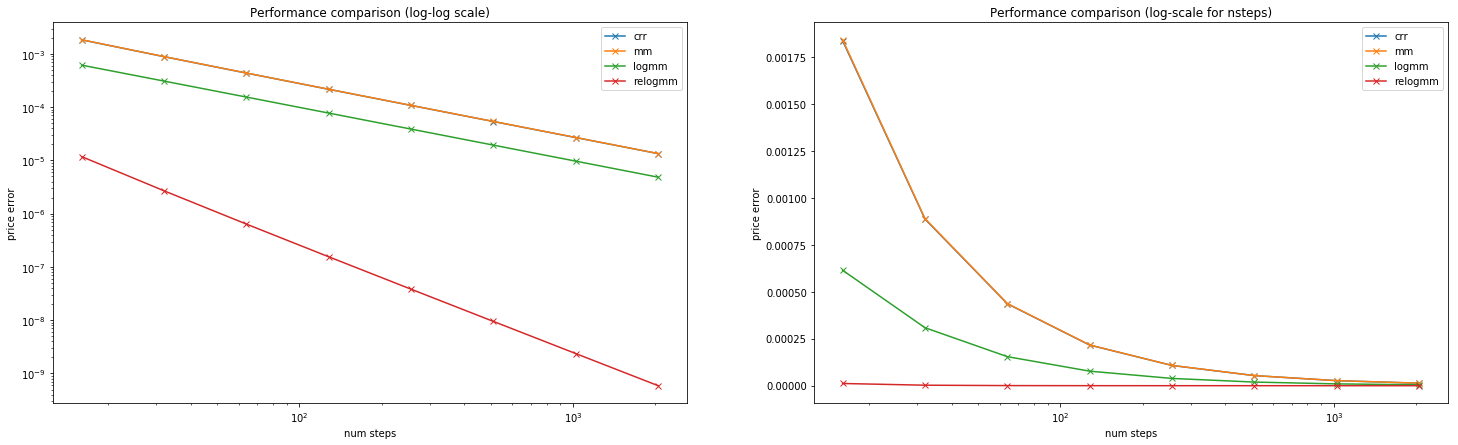

In [43]:
fig, ax = plt.subplots(1,2,figsize=(25,7))

F=1.
K=1.
v=0.2
T=0.25
call = lambda S : np.maximum(S-K,0.0)
put = lambda S : np.maximum(K-S,0.0)
exact = bscall(F,K,v,T)

n = 2**np.arange(4,12)
r_crr = (np.array([run_crr_tree(F,T,v,n_val,put) for n_val in n])-exact)
r_mm = (np.array([run_mm_tree(F,T,v,n_val,put) for n_val in n])-exact)
r_logmm = -(np.array([run_logmm_tree(F,T,K,v,n_val,put) for n_val in n])-exact)
r_rich = np.abs(np.array([run_logmm_rich_tree(F,T,K,v,n_val,put) for n_val in n])-exact)

for ax_ in ax:
    ax_.plot(n,r_crr, label='crr', marker="x")
    ax_.plot(n,r_mm, label='mm', marker="x")
    ax_.plot(n,r_logmm, label='logmm', marker="x")
    ax_.plot(n,r_rich, label='relogmm', marker="x")
    ax_.legend()
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_title("Performance comparison (log-log scale)")
ax[1].set_title("Performance comparison (log-scale for nsteps)")
ax[0].set_xlabel("num steps")
ax[1].set_xlabel("num steps")
ax[0].set_ylabel("price error")
ax[1].set_ylabel("price error")
None

In [44]:
print(run_logmm_tree(F,T,K,v,2^10,put, pad=0), run_logmm_tree(F,T,K,v,2^10,put, pad=1))

0.03865932965709117 0.03865932965709117


In [8]:
import time

/home/sejones/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


10.796875
11.875
0.0


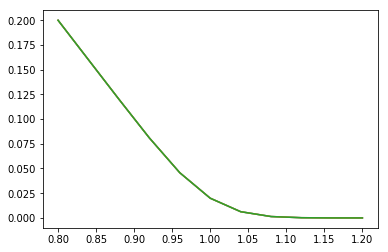

In [11]:
n_val = 1e4
F = np.array(1.).reshape(-1,1)
K = np.linspace(0.8,1.2,11).reshape(1,-1)
T = 0.25
v = 0.1
call_v = lambda S : np.maximum(S-K,0.0)

ebel = time.clock()
tree_result = run_logmm_tree(F,T,F,v,n_val,call_v)
print (time.clock()-ebel)
ebel = time.clock()
individual_tree_result = [run_logmm_tree(1.0,T,1.0,v,n_val,lambda S : np.maximum(S-strike,0.0)) for strike in K.flatten()]
print (time.clock()-ebel)
ebel = time.clock()
exact = bscall(F,K,v,T)
print (time.clock()-ebel)

plt.plot(K.flatten(),exact.flatten())
plt.plot(K.flatten(),tree_result.flatten())
plt.plot(K.flatten(),individual_tree_result)

In [12]:
n = 23

# behaviour is as np.linspace for scalar inputs
from_=1.2
to_=2.3
spaced = linspace(from_, to_, n)
npspaced = np.linspace(from_, to_, n)
assert spaced.shape == npspaced.shape
assert np.all(np.abs(spaced-npspaced)<1e-12)

#behavior is as expected for a multidimensional array
from_ = np.array([[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]]])
to_ = np.array([[[4,5,6],[7,8,9]],[[4,5,6],[7,8,9]],[[4,5,6],[7,8,9]],[[4,5,6],[7,8,9]]])
spaced = (linspace(from_, to_, n))
assert len(spaced.shape)== len(from_.shape)+1
assert spaced.shape[0] == n
assert tuple(list(spaced.shape)[1:])==from_.shape
assert np.all(spaced[0] == from_)
assert np.all(spaced[-1] == to_)